In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

#eazy.symlink_eazy_inputs()

eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', path_is_env=False)




/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
params = {}
params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst_temp.v4.3.cat'

params['MAIN_OUTPUT_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst_new.v4.3'

# Galactic extinction
params['MW_EBV'] = 0.0103

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 205 # HST H-band
params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

In [5]:
translate_file = '/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst_temp.v4.1.translate'
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst_temp.v4.3.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (227): NOAO/k1001bp_jul04.txt
f_F435W e_F435W (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f_G e_G (229): LRIS/g_blue_transmission.dat
f_F606W e_F606W (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_Rs e_Rs (231): LRIS/Rs_LRISred_transmission.dat
f_F775W e_F775W (238): hst/ACS_update_sep07/wfc_f775w_t81.dat
f_F850LP e_F850LP (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_J e_J (224): MOIRCS/J277.txt
f_F140W e_F140W (204): hst/wfc3/IR/f140w.dat
f_H e_H (225): MOIRCS/H117.txt
f_Ks e_Ks (226): MOIRCS/Ks_rot1707wedged120K.txt
f_IRAC1 e_IRAC1 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_IRAC2 e_IRAC2 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC3 e_IRAC3 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC4 e_IRAC4 ( 21): IR

Iteration:  0
37882
Compute best fits
Fit 209.3 s (n_proc=8, NOBJ=37882)
Iteration:  1
37882
Compute best fits
Fit 221.9 s (n_proc=8, NOBJ=37882)
`error_residuals`: force uncertainties to match residuals
Iteration:  2
37854
Compute best fits
Fit 212.4 s (n_proc=8, NOBJ=37854)
`error_residuals`: force uncertainties to match residuals


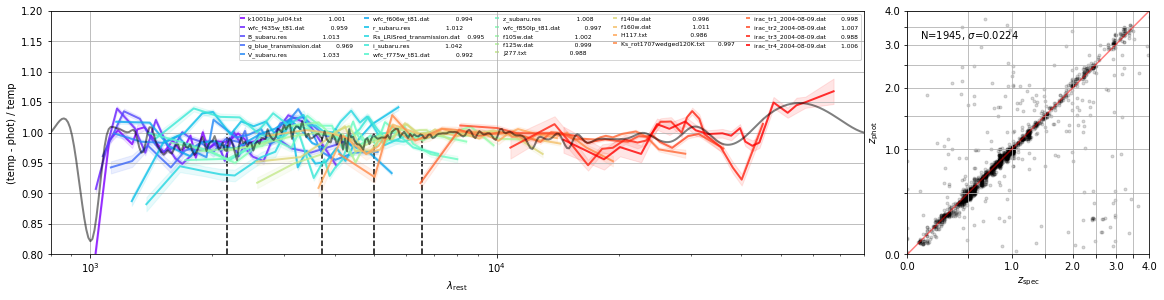

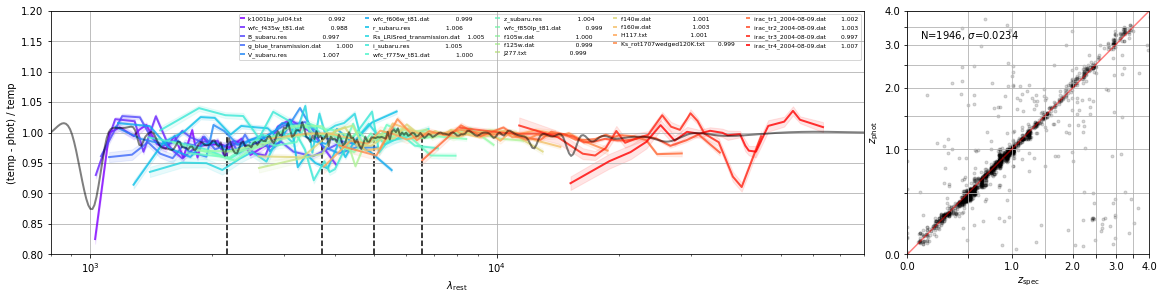

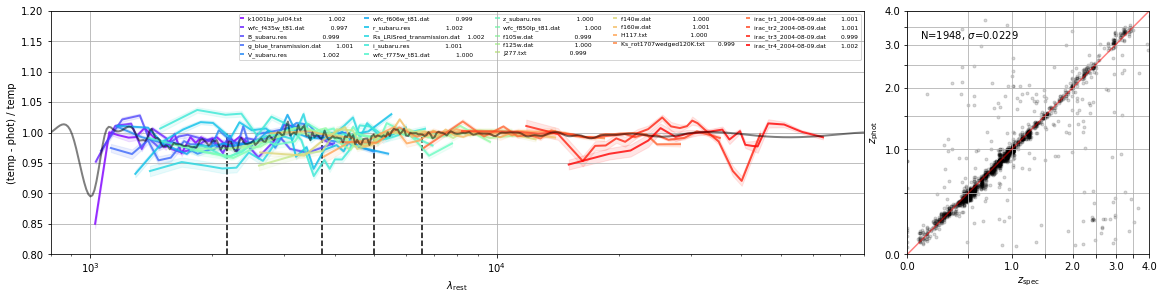

In [6]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    print(len(np.where(clip == True)[0]))
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=(iter > 0), 
                              NBIN=NBIN, get_spatial_offset=False)

In [7]:
# Turn off error corrections derived above
self.efnu = self.efnu_orig*1

# Full catalog
sample = np.isfinite(self.cat['z_spec'])
self.fit_parallel(self.idx[sample], n_proc=8)

Compute best fits
Fit 190.6 s (n_proc=8, NOBJ=38279)


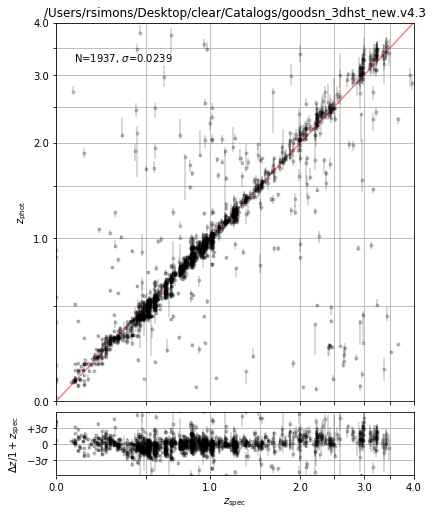

In [8]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [9]:
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, prior=True, beta_prior=True)

Get best fit coeffs & best redshifts
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])
Rest-frame filters: [153, 154, 155, 161]


/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/photoz.py:2280: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Rest-frame filters: [270, 274, 120, 121, 156, 157, 158, 159, 160, 161, 162, 163]


In [13]:
hdu.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ID            1 ImageHDU         7   (38279,)   uint32   
  2  ZBEST         1 ImageHDU         7   (38279,)   float32   
  3  ZGRID         1 ImageHDU         7   (194,)   float32   
  4  CHI2          1 ImageHDU         9   (194, 38279)   float32   
  5  COEFFS        1 ImageHDU        22   (12, 38279)   float64   
  6  TEMPL         1 ImageHDU         7   (5994,)   float64   
  7  TEMPF         1 ImageHDU         8   (5994, 12)   float64   
  8  REST_UBVJ     1 ImageHDU        14   (5, 4, 38279)   float32   


In [29]:
self.write_zeropoint_file(file = 'v4.3_new.zeropoint')